### Feature Engineering

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
# ⚡ Quick Setup - Run after runtime reset (CPU/GPU Switch)
# Installs essential packages silently to save output clutter

!pip install matplotlib seaborn pandas numpy missingno --quiet

print("\033[92m✅ All required packages installed successfully.\033[0m")

✅ All required packages installed successfully.


#### Import libraries

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import shutil

#### Load the EDA & Preprocessing notebook

In [59]:
# df2 = pd.read_parquet("/home/data/processed/PreProcessing.parquet")
df2 = pd.read_parquet("/content/drive/MyDrive/datasets/processed/PreProcessingcolab.parquet")

In [60]:
# prompt: remove the time_idx

df2 = df2.drop('time_idx', axis=1, errors='ignore')

#### Time Based Calender features

In [61]:
df2['hour'] = df2['timestamp'].dt.hour
df2['dayofweek'] = df2['timestamp'].dt.dayofweek
df2['is_weekend'] = df2['dayofweek'] >= 5
df2['month'] = df2['timestamp'].dt.month
df2['day'] = df2['timestamp'].dt.day

#### Cyclical Time Features for Time Series Data

In [62]:
# Cyclical encoding for hour
df2['hour_sin'] = np.sin(2 * np.pi * df2['hour'] / 24).round(4)
df2['hour_cos'] = np.cos(2 * np.pi * df2['hour'] / 24).round(4)

# Same for day of week
df2['dayofweek_sin'] = np.sin(2 * np.pi * df2['dayofweek'] / 7).round(4)
df2['dayofweek_cos'] = np.cos(2 * np.pi * df2['dayofweek'] / 7).round(4)

# Optional month encoding if relevant
df2['month_sin'] = np.sin(2 * np.pi * (df2['month'] - 1) / 12).round(4)
df2['month_cos'] = np.cos(2 * np.pi * (df2['month'] - 1) / 12).round(4)

In [63]:
df2.head()

,timestamp,Timestamp [s],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],...,dayofweek,is_weekend,month,day,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos
0,2013-08-12 13:45:00,1.376315e+09,4.0,11703.99824,10890.570362,93.050000,67108864.0,6.755624e+06,1.333333,19137.333333,...,0,False,8,12,-0.2588,-0.9659,0.0,1.0,-0.5,-0.866
1,2013-08-12 13:50:00,1.376315e+09,4.0,11703.99824,10434.114431,89.150000,67108864.0,8.947846e+06,2.533333,19974.933333,...,0,False,8,12,-0.2588,-0.9659,0.0,1.0,-0.5,-0.866
2,2013-08-12 13:55:00,1.376316e+09,4.0,11703.99824,10539.450415,90.050000,67108864.0,1.879048e+07,5.466667,8791.800000,...,0,False,8,12,-0.2588,-0.9659,0.0,1.0,-0.5,-0.866
3,2013-08-12 14:00:00,1.376316e+09,4.0,11703.99824,10951.041020,93.566667,67108864.0,9.305761e+06,5.400000,15679.533333,...,0,False,8,12,-0.5000,-0.8660,0.0,1.0,-0.5,-0.866
4,2013-08-12 14:05:00,1.376316e+09,4.0,11703.99824,10913.978359,93.250000,67108864.0,6.352970e+06,4.466667,15553.733333,...,0,False,8,12,-0.5000,-0.8660,0.0,1.0,-0.5,-0.866


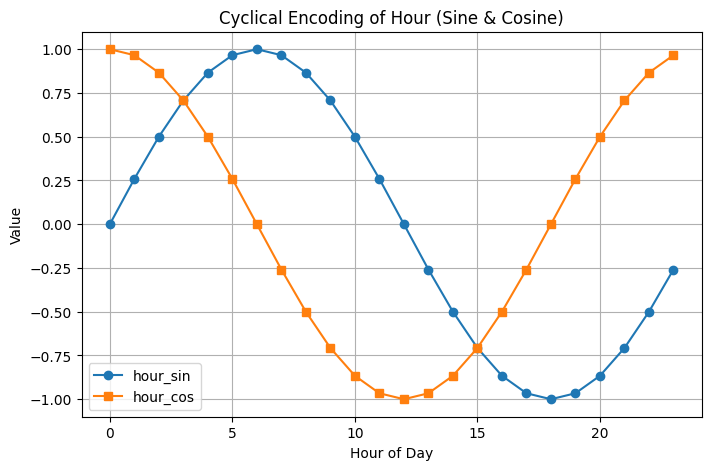

In [64]:
import matplotlib.pyplot as plt

# Example: Plot cyclical encoding for one day (0 to 23 hours)
hours = np.arange(0, 24)
hour_sin = np.sin(2 * np.pi * hours / 24)
hour_cos = np.cos(2 * np.pi * hours / 24)

plt.figure(figsize=(8, 5))
plt.plot(hours, hour_sin, label='hour_sin', marker='o')
plt.plot(hours, hour_cos, label='hour_cos', marker='s')
plt.title("Cyclical Encoding of Hour (Sine & Cosine)")
plt.xlabel("Hour of Day")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

#### Compute the CPU & Memory usage

In [65]:
df2['cpu_utilization_ratio'] = (df2['CPU usage [MHZ]'] / df2['CPU capacity provisioned [MHZ]']).round(4)
df2['memory_utilization_ratio'] = (df2['Memory usage [KB]'] / df2['Memory capacity provisioned [KB]']).round(4)

# Optional: Convert to percentage view for easy debugging (not for modeling)
# df2['cpu_util_percent'] = (df2['cpu_utilization_ratio'] * 100).round(2)
# df2['memory_util_percent'] = (df2['memory_utilization_ratio'] * 100).round(2)

#### Lag Features Trend Detection of CPU & Memory Features

In [66]:
# Resource Utilization Change Features (Trend Detection)

df2['cpu_util_prev'] = df2.groupby('VM')['cpu_utilization_ratio'].shift(1)
df2['cpu_util_diff'] = df2['cpu_utilization_ratio'] - df2['cpu_util_prev']

df2['memory_util_prev'] = df2.groupby('VM')['memory_utilization_ratio'].shift(1)
df2['memory_util_diff'] = df2['memory_utilization_ratio'] - df2['memory_util_prev']

#### Compute the Disk Usage Ratio, Rolling stats

In [67]:
# Total Disk Throughput
df2['disk_total_throughput'] = (
    df2['Disk read throughput [KB/s]'] + df2['Disk write throughput [KB/s]']
)

# Rolling Average and Std for Disk (window size = 5)
df2['disk_rolling_mean'] = (
    df2.groupby('VM')['disk_total_throughput']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df2['disk_rolling_std'] = (
    df2.groupby('VM')['disk_total_throughput']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)

#### Compute the Network Throughput, Rolling stats

In [68]:
# Total Network Throughput
df2['network_total_throughput'] = (
    df2['Network received throughput [KB/s]'] + df2['Network transmitted throughput [KB/s]']
)

# Rolling Average and Std for Network (window size = 5)
df2['network_rolling_mean'] = (
    df2.groupby('VM')['network_total_throughput']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df2['network_rolling_std'] = (
    df2.groupby('VM')['network_total_throughput']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)

####  Lag Features Trend Detection of Disk & Network Features

In [69]:
# -------------------- Disk Features --------------------
if 'Disk read throughput [KB/s]' in df2.columns:
    df2['disk_read_prev'] = df2.groupby('VM')['Disk read throughput [KB/s]'].shift(1)
    df2['disk_read_diff'] = df2['Disk read throughput [KB/s]'] - df2['disk_read_prev']

if 'Disk write throughput [KB/s]' in df2.columns:
    df2['disk_write_prev'] = df2.groupby('VM')['Disk write throughput [KB/s]'].shift(1)
    df2['disk_write_diff'] = df2['Disk write throughput [KB/s]'] - df2['disk_write_prev']

# -------------------- Network Features --------------------
df2['network_received_prev'] = df2.groupby('VM')['Network received throughput [KB/s]'].shift(1)
df2['network_received_diff'] = df2['Network received throughput [KB/s]'] - df2['network_received_prev']

df2['network_transmitted_prev'] = df2.groupby('VM')['Network transmitted throughput [KB/s]'].shift(1)
df2['network_transmitted_diff'] = df2['Network transmitted throughput [KB/s]'] - df2['network_transmitted_prev']

# Total Network Throughput Change per VM
df2['network_total_prev'] = df2.groupby('VM')['network_total_throughput'].shift(1)
df2['network_total_diff'] = df2['network_total_throughput'] - df2['network_total_prev']

#### Resource Utilization Behavior

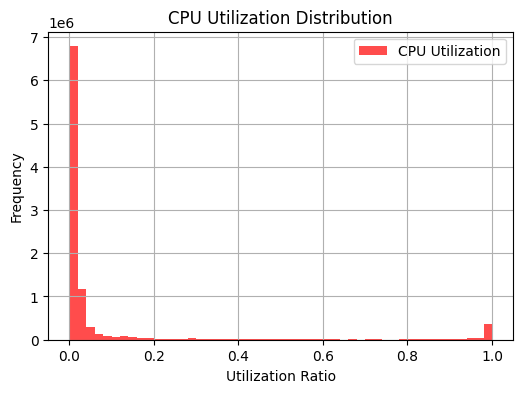

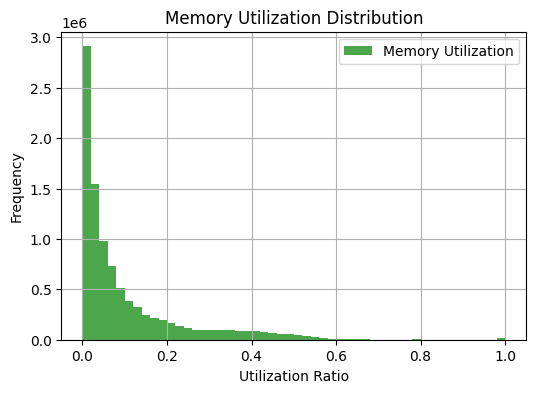

In [70]:
# ✅ First, clip to 0–1 range
df2['cpu_utilization_ratio'] = df2['cpu_utilization_ratio'].clip(0, 1)
df2['memory_utilization_ratio'] = df2['memory_utilization_ratio'].clip(0, 1)

# ✅ Now remove NaNs and infs AFTER clipping
clean_cpu = df2['cpu_utilization_ratio'].replace([np.inf, -np.inf], np.nan).dropna()
clean_mem = df2['memory_utilization_ratio'].replace([np.inf, -np.inf], np.nan).dropna()

# ✅ Plot
plt.figure(figsize=(6, 4))
plt.hist(clean_cpu, bins=50, alpha=0.7, color='red', label='CPU Utilization')
plt.title("CPU Utilization Distribution")
plt.xlabel("Utilization Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(clean_mem, bins=50, alpha=0.7, color='green', label='Memory Utilization')
plt.title("Memory Utilization Distribution")
plt.xlabel("Utilization Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()

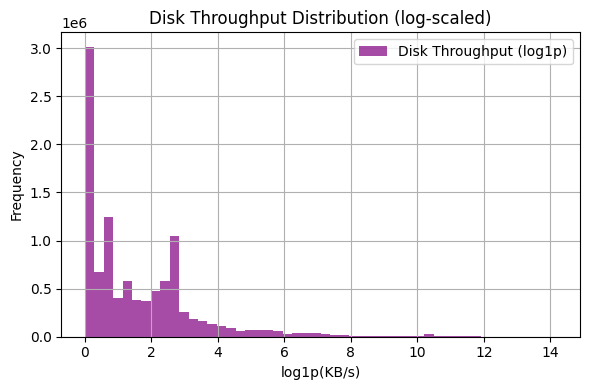

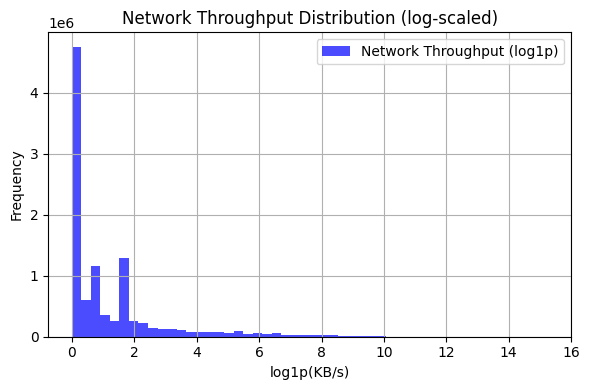

In [71]:
# ✅ Step 1: Clean disk & network throughput columns
clean_disk = df2['disk_total_throughput'].replace([np.inf, -np.inf], np.nan).dropna()
clean_net = df2['network_total_throughput'].replace([np.inf, -np.inf], np.nan).dropna()

# # ✅ Step 2: Apply log1p transformation
log_disk = np.log1p(clean_disk)
log_net = np.log1p(clean_net)

# ✅ Step 3: Plot Disk Throughput Distribution
plt.figure(figsize=(6, 4))
plt.hist(log_disk, bins=50, alpha=0.7, color='purple', label='Disk Throughput (log1p)')
plt.title("Disk Throughput Distribution (log-scaled)")
plt.xlabel("log1p(KB/s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Step 4: Plot Network Throughput Distribution
plt.figure(figsize=(6, 4))
plt.hist(log_net, bins=50, alpha=0.7, color='blue', label='Network Throughput (log1p)')
plt.title("Network Throughput Distribution (log-scaled)")
plt.xlabel("log1p(KB/s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [72]:
df2.columns

Index(['timestamp', 'Timestamp [s]', 'CPU cores',
       'CPU capacity provisioned [MHZ]', 'CPU usage [MHZ]', 'CPU usage [%]',
       'Memory capacity provisioned [KB]', 'Memory usage [KB]',
       'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]',
       'Network received throughput [KB/s]',
       'Network transmitted throughput [KB/s]', 'time_diff', 'VM', 'hour',
       'dayofweek', 'is_weekend', 'month', 'day', 'hour_sin', 'hour_cos',
       'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos',
       'cpu_utilization_ratio', 'memory_utilization_ratio', 'cpu_util_prev',
       'cpu_util_diff', 'memory_util_prev', 'memory_util_diff',
       'disk_total_throughput', 'disk_rolling_mean', 'disk_rolling_std',
       'network_total_throughput', 'network_rolling_mean',
       'network_rolling_std', 'disk_read_prev', 'disk_read_diff',
       'disk_write_prev', 'disk_write_diff', 'network_received_prev',
       'network_received_diff', 'network_transmitted_prev',
       'n

In [73]:
core_utilization_features = [
    "cpu_utilization_ratio",
    "memory_utilization_ratio",
    "disk_total_throughput",
    "network_total_throughput"
]

lag_diff_features = [
    "cpu_util_prev", "cpu_util_diff",
    "memory_util_prev", "memory_util_diff",
    "disk_read_prev", "disk_read_diff",
    "disk_write_prev", "disk_write_diff",
    "network_received_prev", "network_received_diff",
    "network_transmitted_prev", "network_transmitted_diff",
    "network_total_prev", "network_total_diff"
]

rolling_features = [
    "disk_rolling_mean", "disk_rolling_std",
    "network_rolling_mean", "network_rolling_std"
]

time_features = [
    "hour", "day", "dayofweek", "month",
    "hour_sin", "hour_cos",
    "dayofweek_sin", "dayofweek_cos",
    "month_sin", "month_cos",
    "is_weekend"
]

static_features = [
    "VM"  # Include "vm_type" if available
]

timestamp_features = [
    "timestamp", "Timestamp [s]"
]

In [74]:
common_features_all_targets = (
    core_utilization_features +
    lag_diff_features +
    rolling_features +
    time_features +
    static_features +
    timestamp_features
)

In [75]:
df3 = df2[common_features_all_targets].copy()

In [76]:
import missingno as msno
import matplotlib.pyplot as plt

print(df3.isna().sum().sort_values(ascending=False))

cpu_util_diff               687844
memory_util_diff            686289
cpu_util_prev               683725
cpu_utilization_ratio       682593
memory_util_prev            670514
memory_utilization_ratio    669381
disk_rolling_std              5000
disk_rolling_mean             5000
network_rolling_std           5000
network_rolling_mean          5000
network_total_prev            1250
network_total_diff            1250
disk_write_diff               1250
disk_write_prev               1250
network_received_prev         1250
network_received_diff         1250
network_transmitted_diff      1250
network_transmitted_prev      1250
disk_read_prev                1250
disk_read_diff                1250
network_total_throughput         0
disk_total_throughput            0
hour                             0
day                              0
dayofweek                        0
month                            0
hour_sin                         0
hour_cos                         0
dayofweek_sin       

In [77]:
df3 = df3[core_utilization_features + lag_diff_features + rolling_features + time_features + static_features + timestamp_features].copy()

In [78]:
# Step 1: Fill targets with forward-fill + backfill per VM
tarc = ["cpu_utilization_ratio", "memory_utilization_ratio"]
# Use transform instead of apply to maintain the original index
df3[tarc] = df3.groupby("VM")[tarc].transform(lambda x: x.ffill().bfill())

In [79]:
# Step 2: Fill lag/diff columns with 0

df3[lag_diff_features] = df3[lag_diff_features].fillna(0)

In [80]:
# Step 3: Recalculate rolling features to fix NaNs from rolling window start
df3["disk_rolling_mean"] = df3.groupby("VM")["disk_total_throughput"].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df3["disk_rolling_std"] = df3.groupby("VM")["disk_total_throughput"].transform(lambda x: x.rolling(window=5, min_periods=1).std())

df3["network_rolling_mean"] = df3.groupby("VM")["network_total_throughput"].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df3["network_rolling_std"] = df3.groupby("VM")["network_total_throughput"].transform(lambda x: x.rolling(window=5, min_periods=1).std())

In [81]:
# Step 4: Final drop remaining NaNs (if any)
df3.dropna(inplace=True)

In [82]:
import numpy as np

df3.replace([np.inf, -np.inf], np.nan, inplace=True)

In [83]:
import numpy as np

# Check for remaining NaNs
nan_summary = df3.isna().sum()
print("🔍 Remaining NaNs:\n", nan_summary[nan_summary > 0])

# Check for infinities
inf_check = np.isinf(df3.select_dtypes(include=[np.number])).sum()
print("🔍 Infinities:\n", inf_check[inf_check > 0])

🔍 Remaining NaNs:
 cpu_util_prev        4001
cpu_util_diff           3
memory_util_prev    15659
memory_util_diff        4
dtype: int64
🔍 Infinities:
 Series([], dtype: int64)


In [84]:
# View again
inf_cols = ["cpu_util_prev", "cpu_util_diff", "memory_util_prev", "memory_util_diff"]
df3[inf_cols].isna().sum()

,0
cpu_util_prev,4001
cpu_util_diff,3
memory_util_prev,15659
memory_util_diff,4


In [85]:
df3[inf_cols] = df3[inf_cols].fillna(0)

In [86]:
# View again
inf_cols = ["cpu_util_prev", "cpu_util_diff", "memory_util_prev", "memory_util_diff"]
df3[inf_cols].isna().sum()

,0
cpu_util_prev,0
cpu_util_diff,0
memory_util_prev,0
memory_util_diff,0


In [87]:
print(df3.isna().sum().sort_values(ascending=False))

cpu_utilization_ratio       0
memory_utilization_ratio    0
disk_total_throughput       0
network_total_throughput    0
cpu_util_prev               0
cpu_util_diff               0
memory_util_prev            0
memory_util_diff            0
disk_read_prev              0
disk_read_diff              0
disk_write_prev             0
disk_write_diff             0
network_received_prev       0
network_received_diff       0
network_transmitted_prev    0
network_transmitted_diff    0
network_total_prev          0
network_total_diff          0
disk_rolling_mean           0
disk_rolling_std            0
network_rolling_mean        0
network_rolling_std         0
hour                        0
day                         0
dayofweek                   0
month                       0
hour_sin                    0
hour_cos                    0
dayofweek_sin               0
dayofweek_cos               0
month_sin                   0
month_cos                   0
is_weekend                  0
VM        

In [88]:
import numpy as np

# Check for NaNs, Infs, and duplicates
print("🧼 Final Data Validation Summary:")
print("-" * 40)
print(f"🚫 NaNs present: {df3.isna().sum().sum()}")  # Total NaNs
print(f"♾️ Infs present: {np.isinf(df3.select_dtypes(include=[np.number])).sum().sum()}")  # Total Infs
print(f"🌀 Duplicate rows: {df3.duplicated().sum()}")
print(f"✅ Final shape: {df3.shape}")

🧼 Final Data Validation Summary:
----------------------------------------
🚫 NaNs present: 0
♾️ Infs present: 0
🌀 Duplicate rows: 0
✅ Final shape: (10328846, 36)


In [89]:
vm_lengths = df3.groupby("VM").size()

In [90]:
vm_lengths

,0
VM,
1,8638
10,8638
100,8638
1000,8638
1001,8638
...,...
995,8638
996,8638
997,8638


In [91]:
vm_stats = df3.groupby("VM").agg(
    total_rows = ("timestamp", "count"),
    cpu_mean = ("cpu_utilization_ratio", "mean"),
    cpu_std = ("cpu_utilization_ratio", "std"),
    mem_mean = ("memory_utilization_ratio", "mean"),
    mem_std = ("memory_utilization_ratio", "std"),
)

# Calculate nan_ratio separately
vm_stats['nan_ratio'] = df3.isna().mean()

In [92]:
# Step 2: Filter VMs With Enough Length

In [93]:
min_timesteps = 8000
vm_counts = df3.groupby("VM").size()
valid_vms = vm_counts[vm_counts >= min_timesteps].index
df4 = df3[df3["VM"].isin(valid_vms)].copy()

In [94]:
# prompt: print valid_vms

valid_vms

Index(['1', '10', '100', '1000', '1001', '1002', '1005', '1006', '1007',
       '1008',
       ...
       '990', '991', '992', '993', '994', '995', '996', '997', '998', '999'],
      dtype='object', name='VM', length=1154)

In [95]:
def check_time_gaps(df3, threshold_minutes=5):
    bad_vms = []
    for vm, group in df3.groupby("VM"):
        deltas = group["timestamp"].sort_values().diff().dt.total_seconds() / 60
        if deltas.max() > threshold_minutes:
            bad_vms.append(vm)
    return bad_vms

bad_vms = check_time_gaps(df3)
df4 = df3[~df3["VM"].isin(bad_vms)].copy()
print(f"Removed {len(bad_vms)} VMs due to time gaps.")
print(f"Remaining VMs: {df4['VM'].nunique()}")

Removed 409 VMs due to time gaps.
Remaining VMs: 841


In [96]:
def confirm_regular_interval(df, expected_minutes=5):
    irregular_vms = []
    for vm, group in df.groupby("VM"):
        deltas = group.sort_values("timestamp")["timestamp"].diff().dt.total_seconds() / 60
        if not (deltas.dropna() == expected_minutes).all():
            irregular_vms.append(vm)
    return irregular_vms

# Run on df4
irregular_vms = confirm_regular_interval(df4)
print(f"❌ VMs with non-regular 5-min intervals: {len(irregular_vms)}")

❌ VMs with non-regular 5-min intervals: 0


In [97]:
df4["uptime_ratio"] = (df4["cpu_utilization_ratio"] > 0).astype(int).groupby(df4["VM"]).transform("mean")

In [98]:
print(df4[["VM", "uptime_ratio"]].drop_duplicates()["uptime_ratio"].describe())

count    841.000000
mean       0.791934
std        0.337987
min        0.000000
25%        0.542024
50%        1.000000
75%        1.000000
max        1.000000
Name: uptime_ratio, dtype: float64


In [99]:
df4.rename(columns={"VM": "vm_id"}, inplace=True)

In [100]:
df4.sort_values(by=["vm_id", "timestamp"], inplace=True)
df4["time_idx"] = df4.groupby("vm_id").cumcount()

In [101]:
def check_time_idx_continuity(df):
    bad_vms = []
    for vm, group in df.groupby("vm_id"):
        idx = group["time_idx"].values
        expected = np.arange(len(idx))
        if not np.array_equal(idx, expected):
            bad_vms.append(vm)
    return bad_vms

bad_timeidx_vms = check_time_idx_continuity(df4)
print(f"❌ VMs with broken or non-continuous time_idx: {len(bad_timeidx_vms)}")

❌ VMs with broken or non-continuous time_idx: 0


In [102]:
df4.columns

Index(['cpu_utilization_ratio', 'memory_utilization_ratio',
       'disk_total_throughput', 'network_total_throughput', 'cpu_util_prev',
       'cpu_util_diff', 'memory_util_prev', 'memory_util_diff',
       'disk_read_prev', 'disk_read_diff', 'disk_write_prev',
       'disk_write_diff', 'network_received_prev', 'network_received_diff',
       'network_transmitted_prev', 'network_transmitted_diff',
       'network_total_prev', 'network_total_diff', 'disk_rolling_mean',
       'disk_rolling_std', 'network_rolling_mean', 'network_rolling_std',
       'hour', 'day', 'dayofweek', 'month', 'hour_sin', 'hour_cos',
       'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos',
       'is_weekend', 'vm_id', 'timestamp', 'Timestamp [s]', 'uptime_ratio',
       'time_idx'],
      dtype='object')

In [103]:
vm_streaks = df4.groupby("vm_id")["time_idx"].max().reset_index()
vm_streaks.rename(columns={"time_idx": "max_streak"}, inplace=True)

In [104]:
vm_streaks["total_points"] = vm_streaks["max_streak"] + 1

In [110]:
expected_length = 8638  # Or any expected number of points
full_streak_vms = vm_streaks[vm_streaks["total_points"] == expected_length]
print(f"✅ VMs with full streak of {expected_length}: {len(full_streak_vms)}")

✅ VMs with full streak of 8638: 751


In [111]:
df_full_streak = df4[df4["vm_id"].isin(full_streak_vms["vm_id"])].copy()

In [ ]:
## Just Validation

In [112]:
print("🔢 Unique VMs:", df_full_streak["vm_id"].nunique())

🔢 Unique VMs: 751


In [113]:
print(df_full_streak.groupby("vm_id").size().value_counts().sort_index())

8638    751
Name: count, dtype: int64


In [114]:
import numpy as np

print("🚫 NaNs:", df_full_streak.isna().sum().sum())
print("♾️ Infs:", np.isinf(df_full_streak.select_dtypes(include=[np.number])).sum().sum())

🚫 NaNs: 0
♾️ Infs: 0


In [115]:
def check_time_idx_continuity(df):
    for vm, group in df.groupby("vm_id"):
        idx = group["time_idx"].values
        if not (idx == np.arange(len(idx))).all():
            return False
    return True

print("🧩 time_idx continuous:", check_time_idx_continuity(df_full_streak))

🧩 time_idx continuous: True


In [106]:
# Correlation matrix b/w targets

                          cpu_utilization_ratio  memory_utilization_ratio  \
cpu_utilization_ratio                  1.000000                  0.104407   
memory_utilization_ratio               0.104407                  1.000000   
disk_total_throughput                  0.105622                  0.068900   
network_total_throughput               0.112338                  0.034682   

                          disk_total_throughput  network_total_throughput  
cpu_utilization_ratio                  0.105622                  0.112338  
memory_utilization_ratio               0.068900                  0.034682  
disk_total_throughput                  1.000000                  0.222887  
network_total_throughput               0.222887                  1.000000  


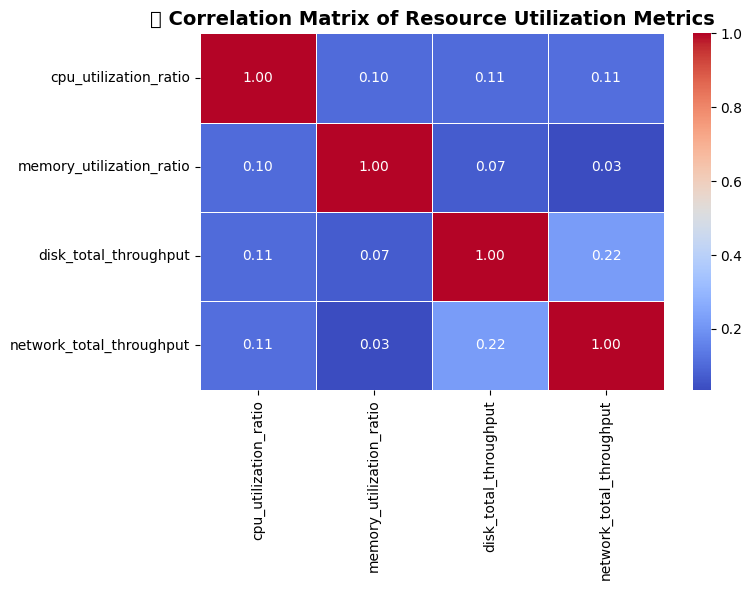

In [116]:
# Define targets
target_cols = [
    'cpu_utilization_ratio',
    'memory_utilization_ratio',
    'disk_total_throughput',
    'network_total_throughput'
]

# Compute correlation matrix
corr_matrix = df_full_streak[target_cols].corr()

print(corr_matrix)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Title and layout
plt.title("🔗 Correlation Matrix of Resource Utilization Metrics", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

In [118]:
# print(df4.shape)

(6845652, 38)


#### Save the cleaned DataFrame to a Parquet file

In [109]:
df_full_streak.to_parquet("/content/drive/MyDrive/datasets/processed/FeatureEng_full_streak.parquet", index=False)

# df2.to_parquet("/content/drive/MyDrive/datasets/processed/FeatureEngcolab.parquet", index=False)

# or

# # Define save path
# save_path = "/content/drive/MyDrive/datasets/processed/FeatureEngcolab"

# # Step 1: Clean old folders
# shutil.rmtree(save_path, ignore_errors=True)

# # Step 2: Re-save from your cleaned df2
# df2.to_parquet(save_path, partition_cols=["VM"], index=False)

# print("✅ Clean overwrite done.")

✅ Clean overwrite done.
